Easy way to train a classifier when you have less labelled data, here we will use 100 images of MNIST only

## Semi-Supervised Classifier

In [1]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.3MB 63kB/s 
     |████████████████████████████████| 491kB 47.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 3.2MB 41.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Reshape,Activation,Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import BatchNormalization,Dropout,Flatten
from keras.datasets import mnist
from keras.models import Sequential,Model
import keras.backend as K
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
img_rows = 28
img_cols = 28
channels = 1
 
img_shape = (img_rows,img_cols,channels)
 
z_dim = 100
num_classes = 10

11493376/11490434 [==============================] - 0s 0us/step
-1.0


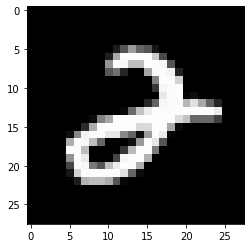

In [4]:
class Dataset:
  def __init__(self,num_labeled,num_classes):
    self.num_labeled = num_labeled
    self.num_classes = num_classes
    (self.x_train,self.y_train),(self.x_test,self.y_test) = mnist.load_data()
  
    def preprocess_image(x):
      x = (x.astype(np.float32)-127.5)/127.5
      x = np.expand_dims(x,axis=-1)
      return x
  
    def preprocess_labels(y):
      return y.reshape((-1,1))
    self.x_train = preprocess_image(self.x_train)
    print(np.min(self.x_train))
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_image(self.x_test)
    self.y_test = preprocess_labels(self.y_test)
 
  def batch_labeled(self,batch_size):
 
    sample_per_class = int(self.num_labeled/self.num_classes)
    imgs = list()
    labels = list()
    for i in range(sample_per_class):
      idx = self.y_train==i
      idx = [i for i, x in enumerate(idx) if x]
      x_classes= self.x_train[idx]
      y_classes = self.y_train[idx]
      #index = np.random.randint(0,x_classes.shape[0],sample_per_class)
      index = np.arange(sample_per_class)
      x_imgs = x_classes[index]
      y_imgs = y_classes[index]
      
      #print(x_imgs.shape)
      [imgs.append(x_imgs[j]) for j in index ]
      [labels.append(y_imgs[j]) for j in range(num_classes)]
 
    imgs = np.asarray(imgs)
    
    labels = np.asarray(labels)
    #print(labels)
 
    ix  = np.random.randint(0,self.num_labeled,batch_size)
    imgs = imgs[ix]
    labels = labels[ix]
    #print(labels.shape)
    return imgs,labels
 
  def batch_unlabeled(self,batch_size):
    idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
    imgs = self.x_train[idx]
    return imgs
 
  def training_set(self):
     x_train = self.x_train[range(self.num_labeled)]  
     y_train = self.y_train[range(self.num_labeled)]
     return x_train ,y_train
  def testing_set(self):
    return self.x_test,self.y_test
 
num_labeled = 100
num_classes = 10
dataset = Dataset(num_labeled,num_classes)
i= dataset.batch_unlabeled(32)
plt.imshow(i[0,:,:,0],cmap='gray')

In [5]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=2,padding='same',activation='tanh'))

  return model

In [6]:
def build_discriminator(img_shape):
  inp = Input(shape=img_shape)

  X = Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same')(inp)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(64,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(128,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  
  X = Flatten(name="flatten")(X)
  X = Dropout(0.5)(X)
  X = Dense(num_classes)(X)
  model = Model(inputs=inp,outputs=X)
  return model

In [7]:
def build_discriminator_supervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  model.add(Activation('softmax'))
  return model

In [9]:
def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
    
  model.add(Lambda(custom_activation))
  
  return model

In [10]:
def build_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [12]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
from keras.utils import to_categorical
x_test,y_test = dataset.testing_set()
y_test = to_categorical(y_test,num_classes)

supervised_losses = []
iteration_checkpoints = []
accuracies = []
val_losses = []
from keras.utils import to_categorical
def train(iterations,batch_size,sample_interval):

  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    imgs,labels = dataset.batch_labeled(batch_size)
    
    #print(labels)
    labels = to_categorical(labels,num_classes=num_classes)

    unlabeled_imgs = dataset.batch_unlabeled(batch_size)

    z = np.random.normal(0,1,(batch_size,z_dim))
    
    fake_imgs = generator.predict(z)
    #print(fake_imgs.shape)

    d_supervised_loss,accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_unsupervised_loss_real = discriminator_unsupervised.train_on_batch(unlabeled_imgs,real)
    d_unsupervised_loss_fake = discriminator_unsupervised.train_on_batch(fake_imgs,fake)
    d_unsupervised_loss = 0.5*np.add(d_unsupervised_loss_real,d_unsupervised_loss_fake)

    z = np.random.normal(0,1,(batch_size,z_dim))
    fake_imgs = generator.predict(z)
    generator_loss = gan.train_on_batch(z,real)

    
    if(iteration+1) % sample_interval ==0:
      supervised_losses.append(d_supervised_loss)
      accuracies.append(100*accuracy)
      iteration_checkpoints.append(iteration+1)
      val_loss = discriminator_supervised.evaluate(x=x_test,y=y_test,verbose=0)
      val_losses.append(val_loss[0])
      print("Iteration No.:",iteration+1,end=",")
      print("Discriminator Supervised Loss:",d_supervised_loss,end=',')
      print('Generator Loss:',generator_loss,end=",")
      print('Discriminator Unsuperived Loss:',d_unsupervised_loss,sep=',')
      print('val_loss:',val_loss,sep=',')
      print('Accuracy Supervised:',100*accuracy)

In [15]:
iterations = 6000
batch_size = 32
sample_interval = 500
train(iterations,batch_size,sample_interval)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration No.: 500,Discriminator Supervised Loss: 0.0013422498,Generator Loss: [0.030874787, 1.0],Discriminator Unsuperived Loss:,[0.00738664 1.        ]
val_loss:,[1.2382528547525407, 0.7024000287055969]
Accuracy Supervised: 100.0
Iteration No.: 1000,Discriminator Supervised Loss: 0.008666657,Generator Loss: [5.794283, 0.0],Discriminator Unsuperived Loss:,[0.10782564 0.96875   ]
val_loss:,[1.2499554376602173, 0.736299991607666]
Accuracy Supervised: 100.0
Iteration No.: 1500,Discriminator Supervised Loss: 0.0031505562,Generator Loss: [3.8865418, 0.0],Discriminator Unsuperived Loss:,[0.07238729 0.96875   ]
val_loss:,[0.6123553897559643, 0.8393999934196472]
Accuracy Supervised: 100.0
Iteration No.: 2000,Discriminator Supervised Loss: 0.0017296828,Generator Loss: [5.250561, 0.0],Discriminator Unsuperived Loss:,[0.06986102 0.96875   ]
val_loss:,[0.5717652545452118, 0.8310999870300293]
Accuracy Supervised: 100.0
Iteration No.: 2500,Discriminator Supervised Loss: 0.004824932,Generator Loss: 

In [16]:
_,accuracy = discriminator_supervised.evaluate(x_test,y_test)
print("Test Accuracy:",accuracy)

10000/10000 [==============================] - 1s 69us/step
Test Accuracy: 0.9146000146865845


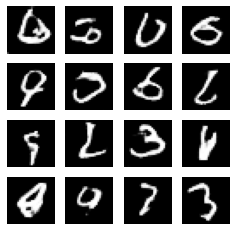

In [17]:
n_rows = 4
fig,axs = plt.subplots(n_rows,n_rows,figsize=(4,4),sharex=True,sharey=True)
z = np.random.normal(0,1,(n_rows**2,z_dim))
#z = z/2 + 0.5
gen_imgs = generator.predict(z)
gen_imgs = gen_imgs/2 + 0.5
count = 0
for i in range(n_rows):
  for j in range(n_rows):
    axs[i,j].imshow(gen_imgs[count,:,:,0],cmap='gray')
    count = count + 1
    axs[i,j].axis('off')

## Compare with Fully Supervised

In [18]:
mnist_classifier = build_discriminator_supervised(
                         build_discriminator(img_shape))     

mnist_classifier.compile(loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [19]:
x_train,y_train =dataset.batch_labeled(100)
mnist_classifier.fit(x=x_train,y=y_train,epochs=100)

Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6234 - accuracy: 0.2100
Epoch 2/100
100/100 [==============================] - 0s 212us/step - loss: 1.0953 - accuracy: 0.6500
Epoch 3/100
100/100 [==============================] - 0s 209us/step - loss: 0.5256 - accuracy: 0.8300
Epoch 4/100
100/100 [==============================] - 0s 193us/step - loss: 0.3672 - accuracy: 0.9300
Epoch 5/100
100/100 [==============================] - 0s 196us/step - loss: 0.2519 - accuracy: 0.9100
Epoch 6/100
100/100 [==============================] - 0s 199us/step - loss: 0.1135 - accuracy: 0.9900
Epoch 7/100
100/100 [==============================] - 0s 192us/step - loss: 0.1034 - accuracy: 0.9900
Epoch 8/100
100/100 [==============================] - 0s 221us/step - loss: 0.0670 - accuracy: 0.9900
Epoch 9/100
100/100 [==============================] - 0s 185us/step - loss: 0.0460 - accuracy: 0.9900
Epoch 10/100
100/100 [==============================] - 0s 227us/step - los

In [20]:

x,y = dataset.testing_set()
_,accuracy = mnist_classifier.evaluate(x,y)
print("Test Accuracy for fully supervised classifier:",accuracy*100)

10000/10000 [==============================] - 1s 80us/step
Test Accuracy for fully supervised classifier: 64.92999792098999
